# Neural Style Transfer

## The notebook demonstrates the implementation and usage of Neural Style Trasnfer techinque which optimizes content image to a particular style. The Algorithm includes the folowing steps.

1. **Feature Extraction**  
   A pre-trained network (e.g., VGG16) extracts feature maps from both the content and style images.

2. **Content Loss**  
   The content loss measures the difference between the feature representation of the generated image and the content image. This ensures the generated image retains the structural elements of the content image.

3. **Style Loss**  
   The style loss compares the correlations between feature maps (using Gram matrices) of the generated image and the style image. This enforces that the generated image captures the stylistic patterns of the style image.

4. **Optimization**  
   An iterative process adjusts the pixels of the generated image to minimize a weighted combination of the content and style losses.

For detailed explanation of the algorithm see the original [paper](https://arxiv.org/abs/1508.06576)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/NeuralStyleTransfer

/content/drive/MyDrive/Colab Notebooks/NeuralStyleTransfer


## Image Preprocessing

In [2]:
# defining content image and style image path
style_path = "style_pop_art.webp"
content_path = "conent.jpg"

In [3]:
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert('RGB')

    # Resize the image if it's too large
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mean and std of vgg16
    ])

    # Add a batch dimension for vgg16 forward pass
    image = transform(image).unsqueeze(0)
    return image

# Defining a function to convert a tensor back to an image
def tensor_to_image(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    #image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    return Image.fromarray(image)

In [6]:
# Creating tensor representation of content_image and style_image for later usage
content_image = load_image(content_path)
style_image = load_image(style_path)

Content Image


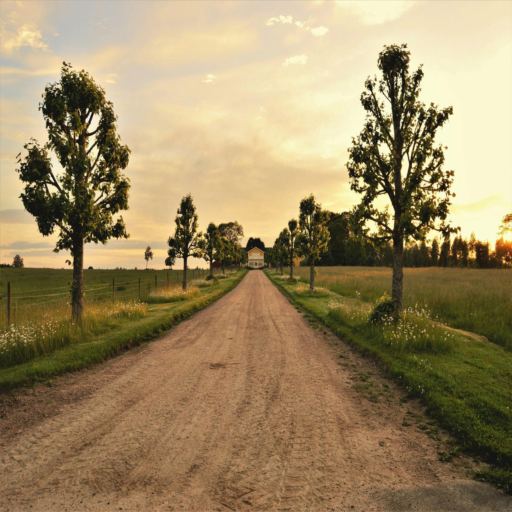

In [9]:
print('Content Image')
tensor_to_image(content_image)

style image


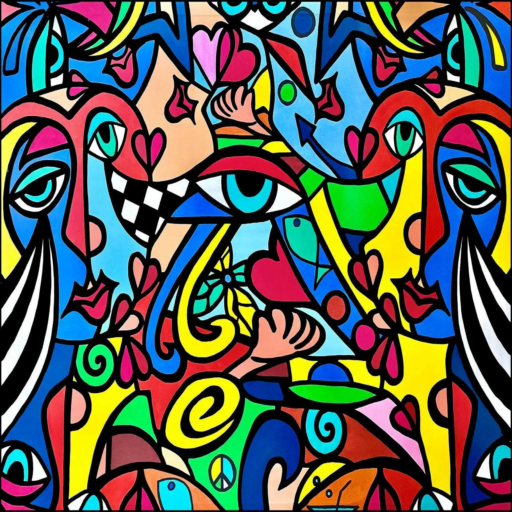

In [11]:

print('style image')
tensor_to_image(style_image)

This is the most effective style image I could find.

## Model Definition

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [60]:
def run_style_transfer(content_image, style_image, device, saving_file_name, num_steps=300, save=False):


    content_image = content_image.to(device)
    style_image = style_image.to(device)

    # Create=ing the initial input image from the content image.
    input_image = content_image.clone().detach().requires_grad_(True)


    # Loading pre-trained VGG16 model features and freezing parameters.
    vgg = vgg16(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad = False

    # Defining device and moving the model and images to GPU if available.
    vgg.to(device)
    #input_image = input_image.to(device)

    # Extracting features from the content and style images.
    content_features = get_features(content_image, vgg)
    style_features = get_features(style_image, vgg)

    # Computing gram matrices for the style features.
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # style weights for each layer.
    style_weights = {
        'conv1_1': 1.0,
        'conv2_1': 0.8,
        'conv3_1': 0.5,
        'conv4_1': 0.3,
        'conv5_1': 0.1
    }

    # Defining content and style loss weights.
    content_weight = 0.2
    style_weight = 0.8

    # Defining optimizer and loss function.
    optimizer = optim.Adam([input_image], lr=0.005)
    criterion = nn.MSELoss()

    # optimization loop.
    i = 0
    for step in range(num_steps):
        # Extracting features from the current input image.
        input_features = get_features(input_image, vgg)

        # Calculating the content loss.
        content_loss = criterion(input_features['conv4_2'], content_features['conv4_2'])

        # Calculating the style loss.
        style_loss = 0
        for layer in style_weights:
            input_gram = gram_matrix(input_features[layer])
            style_gram = style_grams[layer]
            layer_loss = style_weights[layer] * criterion(input_gram, style_gram)
            style_loss += layer_loss / input_gram.numel()

        # Total loss is a weighted sum of content and style losses.
        total_loss = content_weight * content_loss + style_weight * style_loss

        # Backpropagation.
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()


        if step % 50 == 0:
            print(f"Step {step}, Total Loss: {total_loss.item():.4f}")

    #Optionally save the image
    if save:
        output_image = tensor_to_image(input_image)
        output_image.save(f'{saving_file_name}')

    return tensor_to_image(input_image)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Total Loss: 8704493.0000
Step 50, Total Loss: 6521627.5000
Step 100, Total Loss: 4428697.0000
Step 150, Total Loss: 3226395.2500
Step 200, Total Loss: 2489850.0000
Step 250, Total Loss: 1936962.8750
helo


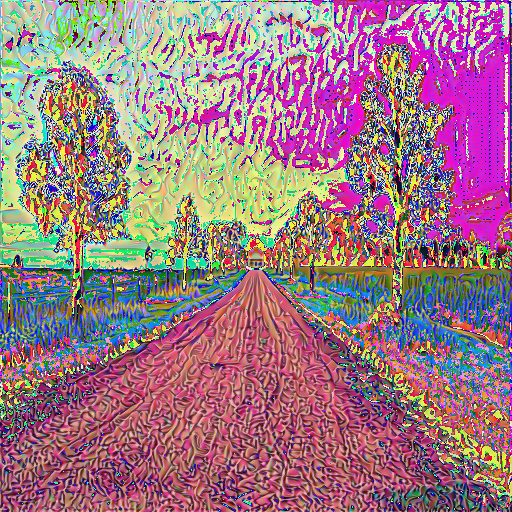

In [44]:
run_style_transfer(content_image, style_image, device, num_steps=300, save=True)

Let's use different style image with the same content image

In [12]:
another_style_path = 'style_brownish.jpg'

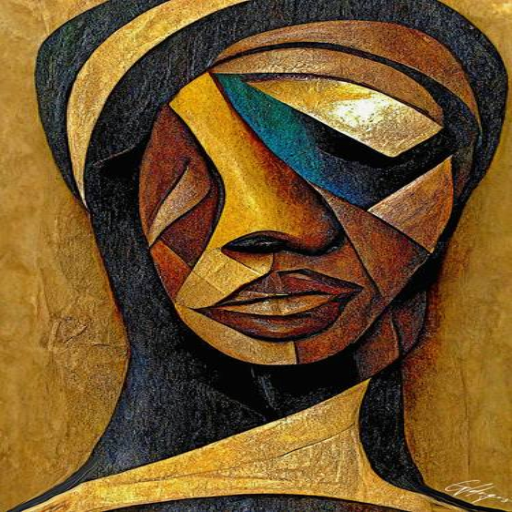

In [13]:
style = load_image(another_style_path)
tensor_to_image(style)

Step 0, Total Loss: 144520.8281
Step 50, Total Loss: 57147.3320
Step 100, Total Loss: 30992.6777
Step 150, Total Loss: 19273.6582
Step 200, Total Loss: 13318.3818
Step 250, Total Loss: 9927.2695


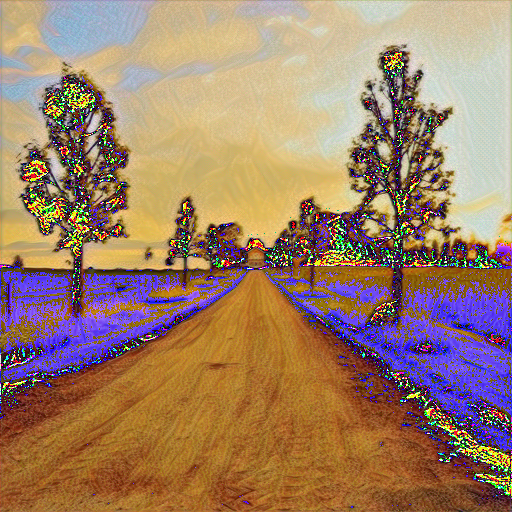

In [64]:
run_style_transfer(content_image, style, device, saving_file_name='output2.jpeg', num_steps=300, save=True)